# Advanced Computerized Tomography with Pyxu

The [introductory tutorial](../intro/tomo.html) on tomography showed how to simulate a tomographic setup using Pyxu,
where we piggy-backed on the
`radon()`[🔗](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.radon) and
`iradon()`[🔗](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.iradon) functions from
`scikit-image` to define the `apply` and `adjoint` methods of the Radon operator.

While we could obtain good reconstructions with this Radon implementation, scikit's operator is limited to 2D parallel
beam projections: there is no support for alternative scanning geometries such as fan-beam. Moreover 3D transforms are
unavailable.

This notebook is focused around Pyxu's
`XRayTransform()`[🔗](../api/experimental/xray.html#pyxu.experimental.xray.XRayTransform) class, a flexible frontend to
2 high-performance Radon/XRay implementations for 2D/3D setups. The goal is to show how to create different scanning
geometries and their effect on image quality **if we do not perform regularization**.

Let's get started!

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage as ski
import warnings as warn
import pyxu.experimental.xray as pxr

warn.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = [4, 4]
plt.rcParams["figure.dpi"] = 300
plt.rcParams["axes.grid"] = True
plt.rcParams["image.cmap"] = "Greys"
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['axes.titlesize'] = 8
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6


## Preliminaries

The X-Ray Transform (XRT) of a function $f: \mathbb{R}^{D} \to \mathbb{R}$ is defined as
$$
    \mathcal{P}[f](\mathbf{n}, \mathbf{t})
    =
    \int_{\mathbb{R}} f(\mathbf{t} + \mathbf{n} \alpha) d\alpha,
$$
where $\mathbf{n}\in \mathbb{S}^{D-1}$ and $\mathbf{t} \in \mathbf{n}^{\perp}$.  $\mathcal{P}[f]$ hence denotes the set
of *line integrals* of $f$.

Two class of algorithms exist to evaluate the XRT:

* **Fourier methods** leverage the [Fourier Slice Theorem (FST)](https://en.wikipedia.org/wiki/Projection-slice_theorem)
    to efficiently evaluate the XRT *when multiple values of* $\mathbf{t}$ *are desired for each* $\mathbf{n}$.
* **Ray methods** compute estimates of the XRT via quadrature rules by assuming $f$ is piecewise constant on short
    intervals.

Pyxu's `XRayTransform()`[🔗](../api/experimental.xray.html#pyxu.experimental.xray.XRayTransform) efficiently
evaluates samples of the XRT assuming $f$ is a pixelized image/volume where:

* the lower-left element of $f$ is located at $\mathbf{o} \in \mathbb{R}^{D}$,
* pixel dimensions are $\mathbf{\Delta} \in \mathbb{R}_{+}^{D}$, i.e.

$$
    f(\mathbf{r}) = \sum_{\{\mathbf{q}\} \subset \mathbb{N}^{D}}
                    \alpha_{\mathbf{q}}
                    1_{[\mathbf{0}, \mathbf{\Delta}]}(\mathbf{r} - \mathbf{q} \odot \mathbf{\Delta} - \mathbf{o}),
    \quad
    \alpha_{\mathbf{q}} \in \mathbb{R}.
$$

In the 2D case, the parametrization is best explained by the figure below:
<center>
<img align="center" src="../_static/api/xray/xray_parametrization.svg" alt="2D XRay Geometry" width=35%>
</center>

## 2D Imaging

Let's try to reconstruct a phantom using different scanning geometries, each having the same number of total rays cast into the medium:

* 2D parallel beam with equi-spaced offsets.
* 2D parallel beam with non-uniform offsets.
* 2D fan beam.

We will use the phantom below for all experiments.

Text(0.5, 1.0, 'Phantom')

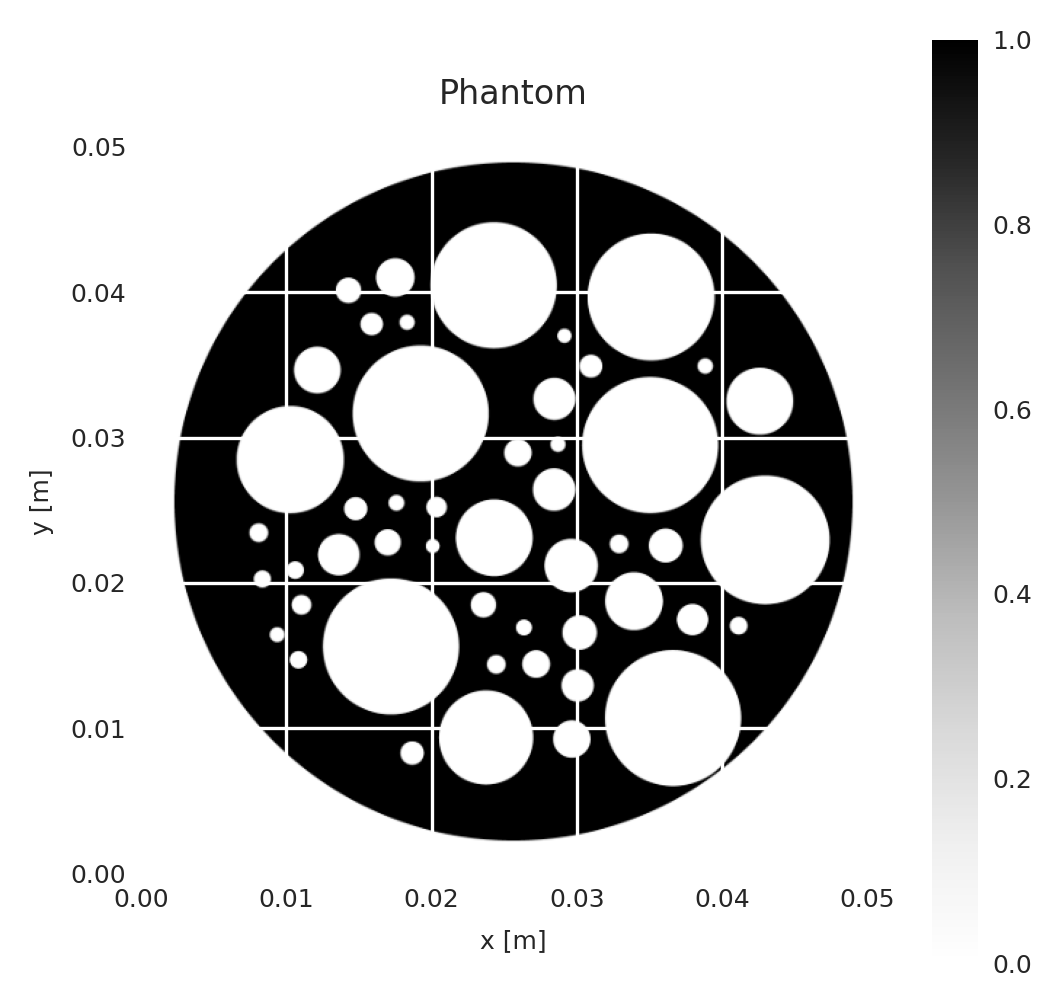

In [19]:
def create_2D_phantom(shape: tuple[int], seed: int) -> np.ndarray:
    # in: (N_h, N_w) phantom dimensions [px]
    # out: (N_h, N_w) phantom
    import xdesign as xd

    np.random.seed(seed)
    substrate = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
    I = xd.discrete_phantom(substrate, np.mean(shape, dtype=int))  # produce image at average resolution
    I = np.pad(I, int(0.05 * I.shape[0]))  # 5% axial pad

    I = ski.transform.rescale(I, scale=np.array(shape) / I.shape[0])  # rescale to user dimensions
    I = (I - I.min()) / I.ptp()
    return I

N_side = 512  # N_px = N_side**2
pitch = 1e-4  # m/px [can differ per axis]
phantom = create_2D_phantom(shape=(N_side, N_side), seed=5)
im_kwargs = dict(
    origin="lower",
    extent=[0, N_side * pitch, 0, N_side * pitch],
)

fig, ax = plt.subplots()
im = ax.imshow(phantom, **im_kwargs)
fig.colorbar(im)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Phantom")


### Parallel Beam: Uniform Offsets

Let's first look at a baseline setup similar to what `scikit-image`'s
`radon()`[🔗](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.radon) and
`iradon()`[🔗](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.iradon) functions would
produce: a parallel-beam scan with equi-spaced lines and uniformly-distributed scan directions.

In [3]:
N_angle = 100
N_offset = 200

# Let's build the necessary components to instantiate the operator. ========================
angle = np.linspace(0, np.pi, N_angle, endpoint=False)
n = np.stack([np.cos(angle), np.sin(angle)], axis=1)

t = n[:, [1, 0]]  # <n, t> = 0
t_max = pitch * N_side / 2 * 1.1  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
# ==========================================================================================

op_para_u = pxr.XRayTransform.init(
    arg_shape=(N_side, N_side),
    origin=0,  # bottom-left corner of volume located at (0, 0)
    pitch=pitch,  # pixel dimensions. (Can vary per axis.)
    method="ray-trace",
    n_spec=n_spec.reshape(-1, 2),  # (N_ray, 2) directions
    t_spec=t_spec.reshape(-1, 2),  # (N_ray, 2)
)


It can be tricky to correctly parametrize the rays.
The `diagnostic_plot()` method can be used to verify everything is correct.
By default `diagnostic_plot()` shows all rays going through the volume.
For visualization purposes, let's only plot every $N$-th angle and $K$-th offset.

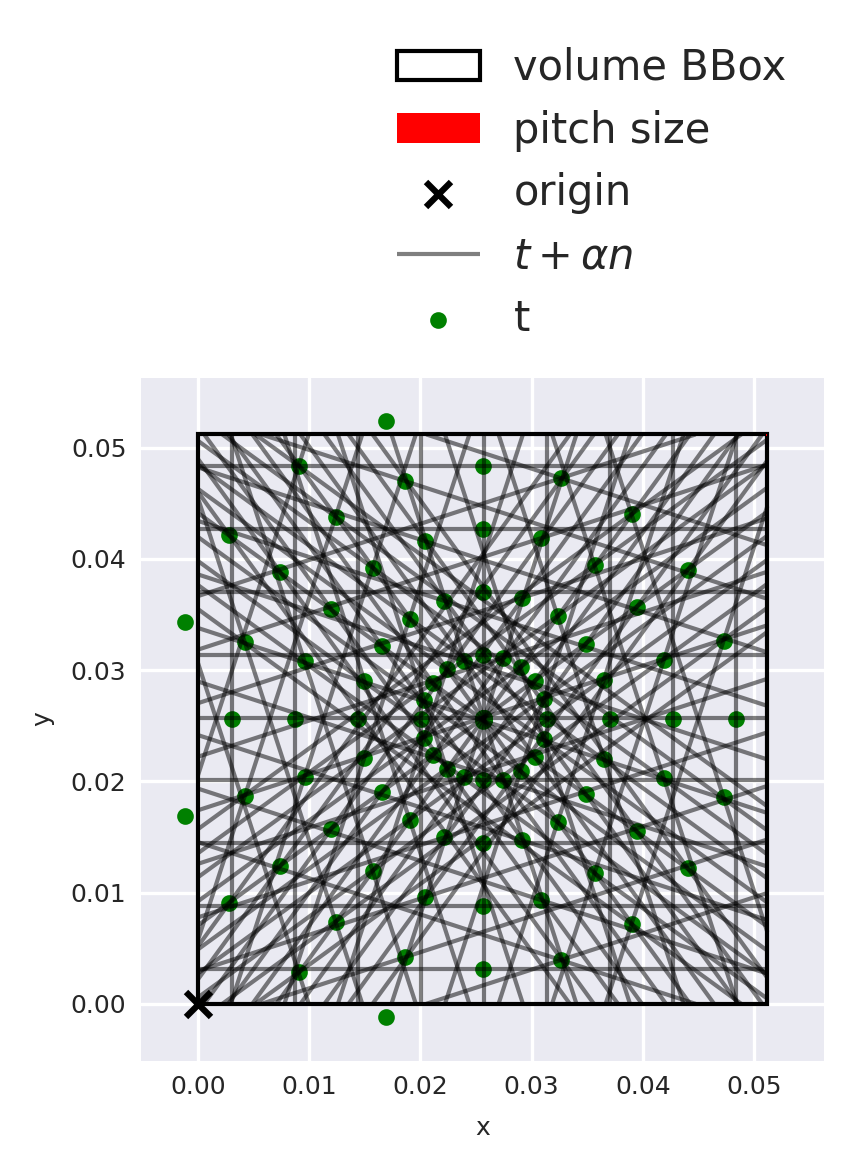

In [18]:
N, K = 10, 20
ray_idx = np.arange(N_angle * N_offset).reshape(N_angle, N_offset)[::N,::K]

fig = op_para_u.diagnostic_plot(ray_idx)
fig.show()


The construction seems ok for a parallel-beam scan: angles/offsets are distributed uniformily, and we can already see that the lines *concentrate* in the center of the volume. (More on this later.)

Now that we created the XRay operator, let's compute the sinogram and visualize it.

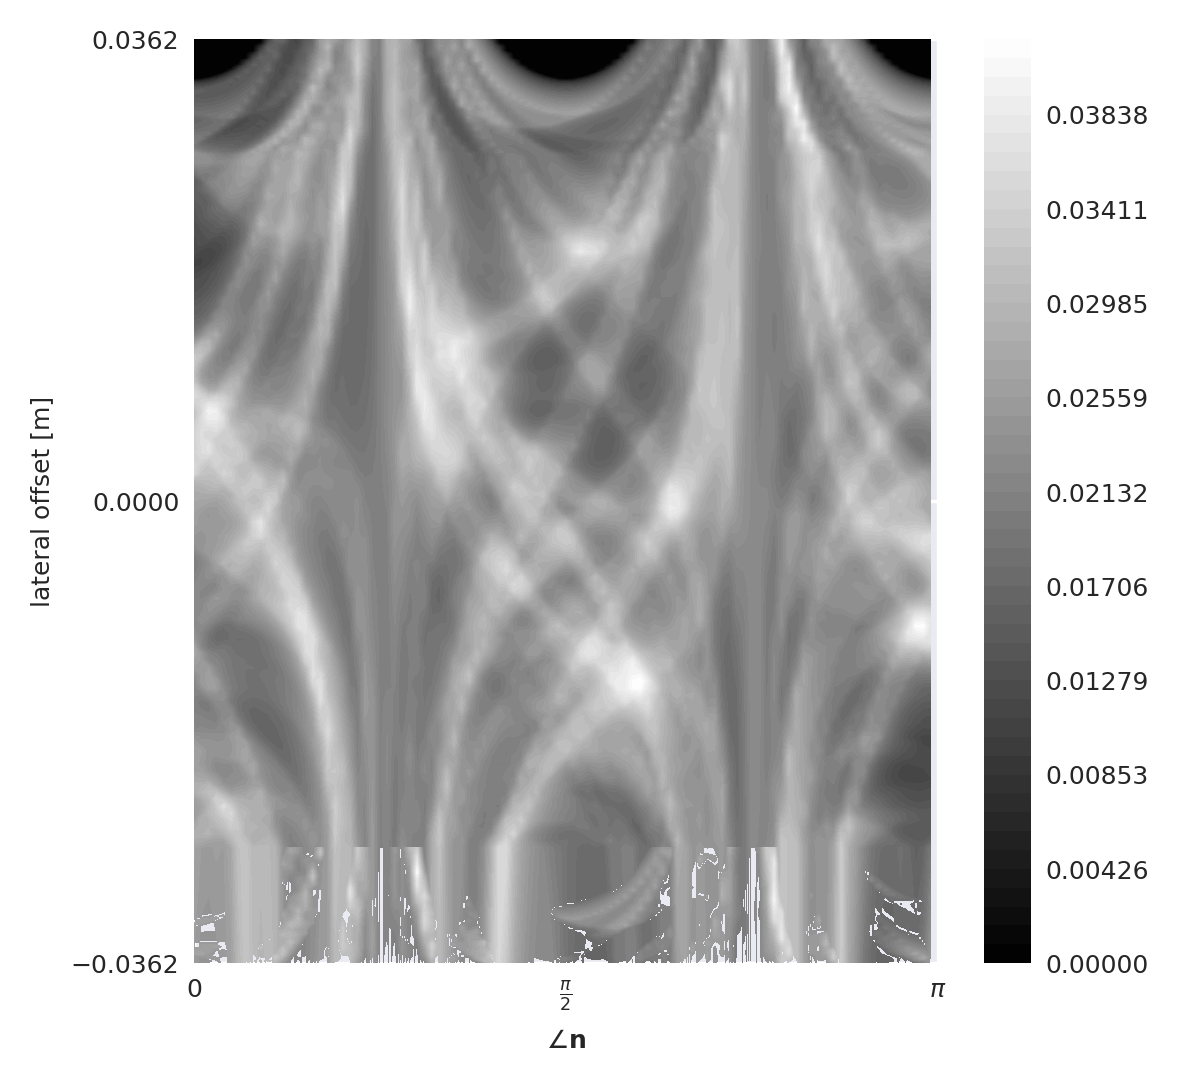

In [20]:
# Compute sinogram
sinogram = op_para_u.apply(phantom.reshape(-1)).reshape(N_angle, N_offset)  # (N_angle, N_offset)


# And plot it
N_level = 50
fig, ax = plt.subplots()
ANGLE, OFFSET = np.meshgrid(angle, t_offset, indexing="ij")
contour = ax.contourf(
    ANGLE,
    OFFSET,
    sinogram,
    levels=np.linspace(0, sinogram.max(), N_level),
    cmap='grey',
)
cbar = fig.colorbar(contour, ax=ax)
ax.set_xlabel(r"$\angle \mathbf{n}$")
ax.set_xticks(
    ticks=[0, np.pi/2, np.pi],
    labels=["0", r"$\frac{\pi}{2}$", r"$\pi$"],
)
ax.set_ylabel(r"lateral offset [m]")
ax.set_yticks(
    ticks=[t_offset.min(), 0, t_offset.max()],
    labels=None,
);


Now that we have the sinogram, let's invert the imaging process to (try to) reconstruct an image which produced it.
We will try 2 methods:

* Plain back-projection of the sinogram data into the image domain.
* Forming the least-squares image. The conventional Filtered-BackProjection algorithm (FBP) should produce similar images, but let's stick to an undampened CG method to compute the pseudo-inverse for simplicity.

INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:21.625205] Iteration 0
	iteration: 0
	AbsError[residual]: 0.05687622737895547
	N_iter: 1.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:22.035556] Iteration 1
	iteration: 1
	AbsError[residual]: 0.06557017379381164
	N_iter: 2.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:22.436203] Iteration 2
	iteration: 2
	AbsError[residual]: 0.005995962885020177
	N_iter: 3.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:22.821280] Iteration 3
	iteration: 3
	AbsError[residual]: 0.00200349375989515
	N_iter: 4.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:23.230381] Iteration 4
	iteration: 4
	AbsError[residual]: 0.008496910984158959
	N_iter: 5.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:23.617034] Iteration 5
	iteration: 5
	AbsError[residual]: 0.0009511932090629814
	N_iter: 6.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:24.036326] Iteration 6
	iteration: 6
	AbsError[residual]: 0.0005980549190576326
	N_iter: 7.0
INFO:/tmp/pyxu_nqhe46r2:[2023-11-02 15:05:24.479982] Iteration 

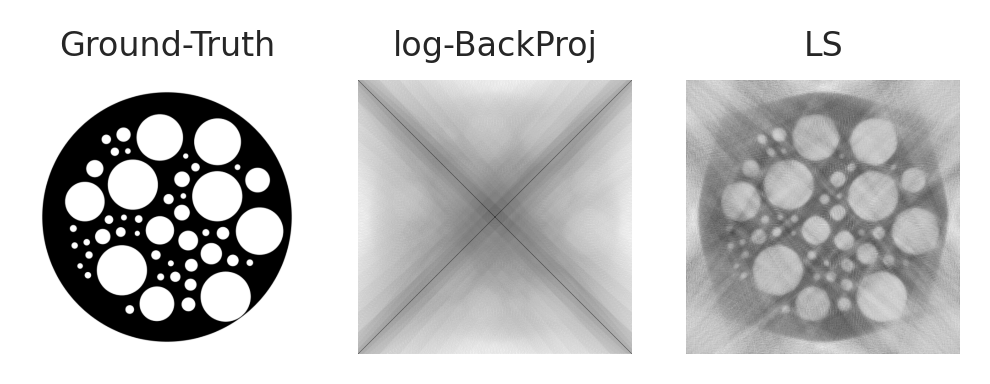

In [21]:
# Compute backprojected image and LSQ image. =======================
I_BP = op_para_u.adjoint(sinogram.reshape(-1)).reshape(phantom.shape)
I_LSQ = op_para_u.pinv(sinogram.reshape(-1), damp=0).reshape(phantom.shape)

# Plot the images ==================================================
fig, ax = plt.subplots(1, 3, figsize=[4, 6])
ax[0].imshow(phantom, **im_kwargs)
ax[1].imshow(np.log(I_BP), **im_kwargs)
ax[2].imshow(I_LSQ, **im_kwargs)
ax[0].set_title("Ground-Truth")
ax[1].set_title("log-BackProj")
ax[2].set_title("LS")
for _ax in ax:
    _ax.axis("off")

# aliases to compare against fan-beam later on.
I_BP_u = I_BP
I_LSQ_u = I_LSQ


Some high-level remarks just by looking at these images:

* The backprojected image has very low contrast: we barely can make out the porous structures in the background, even in
  log-scale.
* The least-squares image allows us to identify the porous structure more easily. However the peripheral region is
  significantly more "blurry" than the central region.  This is because the ray density is higher in the central region
  than in the periphery.

### Parallel Beam: Non-Uniform Offsets

One option to homogenize radial resolution is to move away from uniformly sampling $t \in [-t_{\mathrm{offset}}^{\max},
t_{\mathrm{offset}}^{\max}]$, and instead sample it more densely at the peripheral regions. Let's define a radius $r \in
]0, t_{\mathrm{offset}}^{\max}[$ such that the number of offsets inside/outside the boundary are equal. We'll image the
phantom at different $r$ values and see how the radial resolution changes.

In [30]:
# We only need to change `t_spec` to create our non-uniformly sampled XRT.
radial_threshold = np.r_[0.15, 0.3, 0.55]

op_para_nu = []
for rt in radial_threshold:
    # Let's build the necessary components to instantiate the operator. ========================
    t_max = pitch * N_side / np.sqrt(2)  # we go until the diagonal max size now.
    t_offset_inside = np.linspace(-t_max * rt, t_max * rt, N_offset//2, endpoint=False)
    t_offset_outside = np.linspace(t_max * rt, t_max, N_offset//4, endpoint=True)
    t_offset = np.r_[-t_offset_outside, t_offset_inside, t_offset_outside]


    t_spec = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
    t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
    # ==========================================================================================

    op = pxr.XRayTransform.init(
        arg_shape=(N_side, N_side),
        origin=0,  # bottom-left corner of volume located at (0, 0)
        pitch=pitch,  # pixel dimensions. (Can vary per axis.)
        method="ray-trace",
        n_spec=n_spec.reshape(-1, 2),  # (N_ray, 2) directions
        t_spec=t_spec.reshape(-1, 2),  # (N_ray, 2)
    )
    op_para_nu.append((rt, op))


Let's look again at `diagnostic_plot()` to make sure the offsets are effectively non-uniform.
(We'll plot one angle only for visualization purposes.)

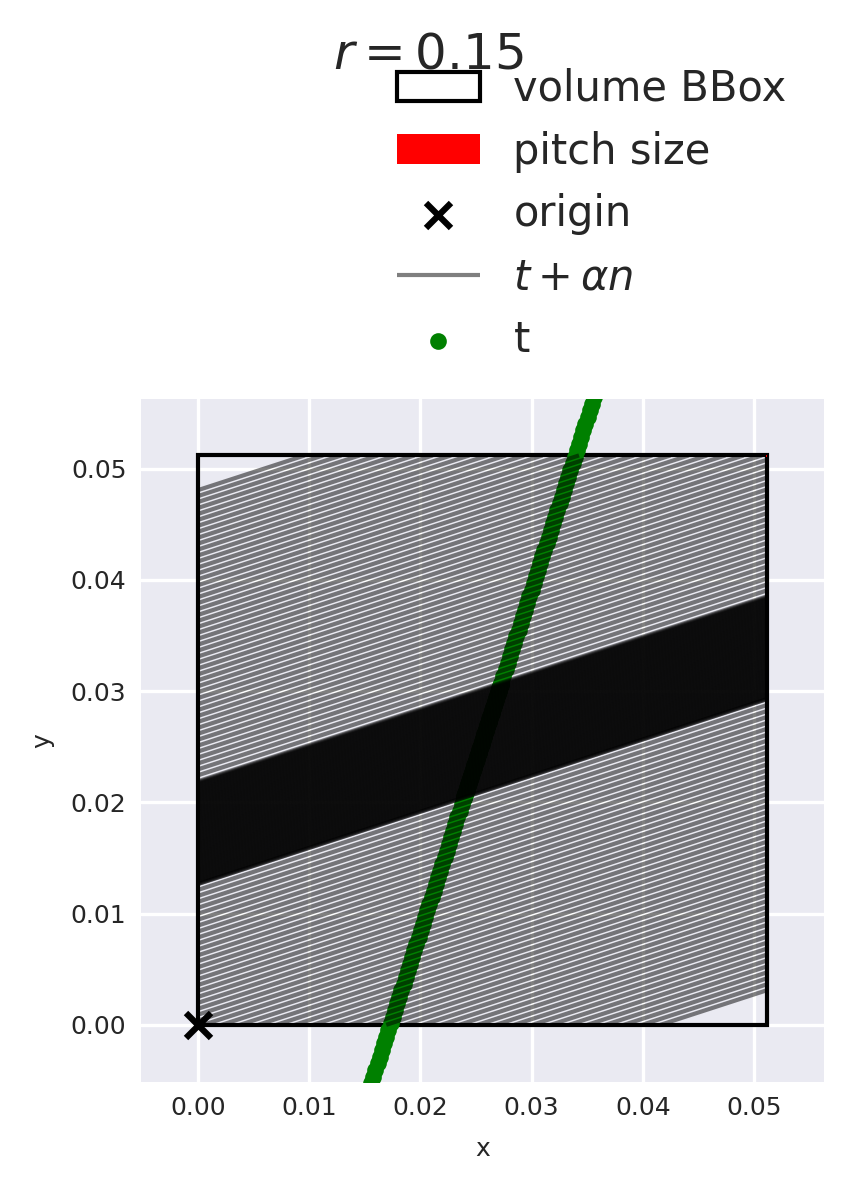

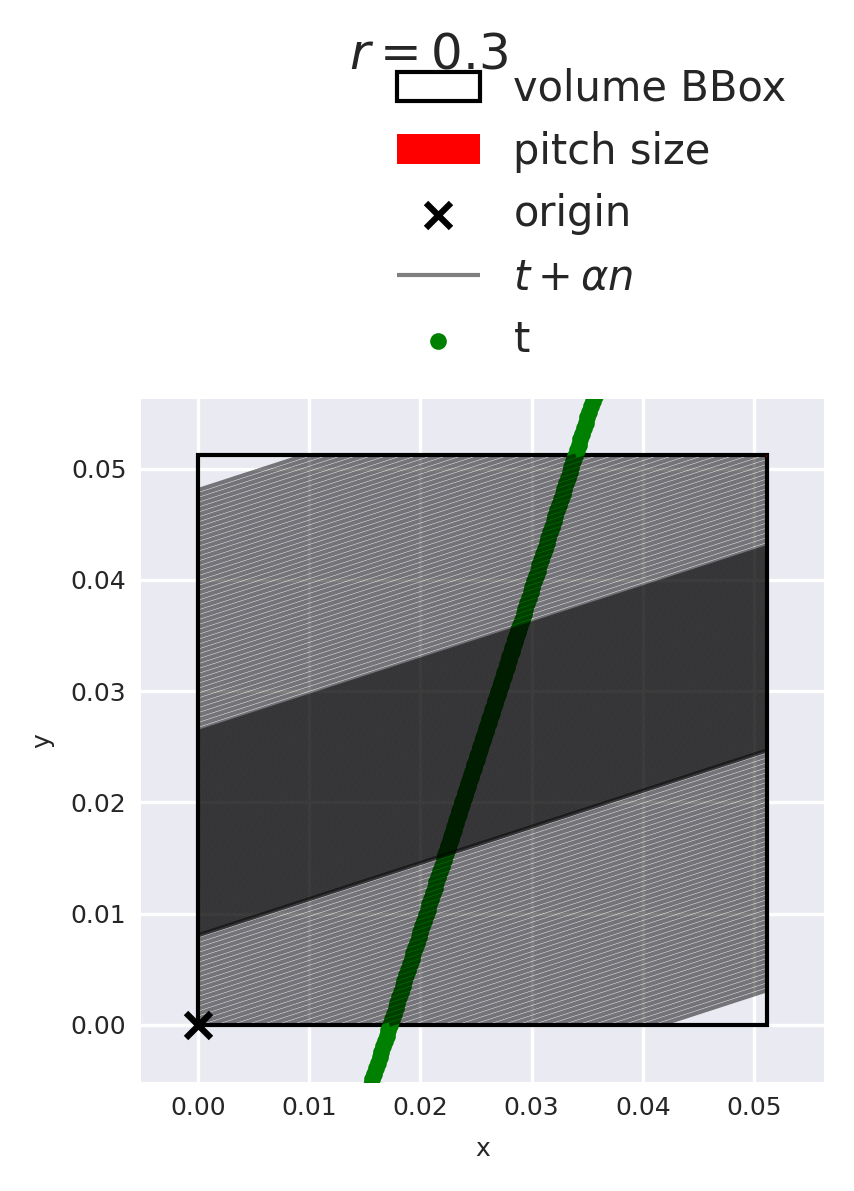

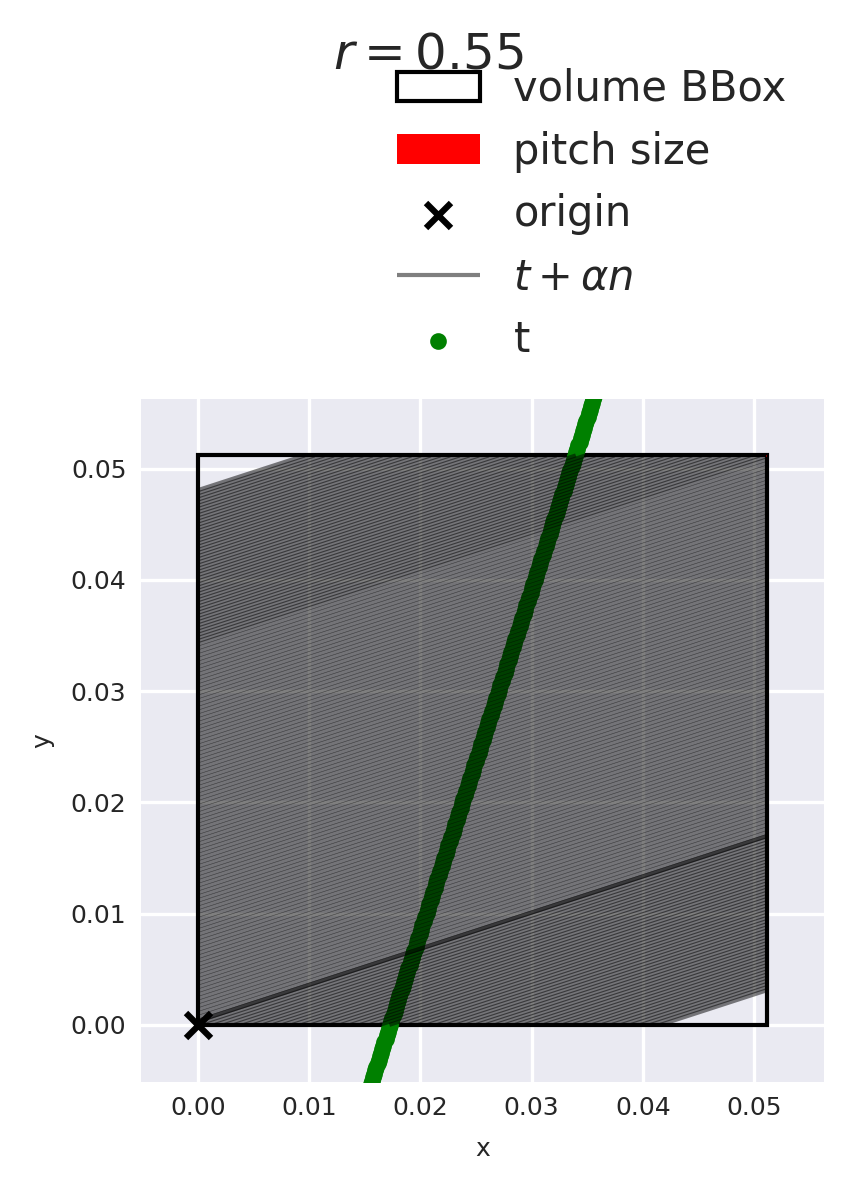

In [32]:
ray_idx = np.arange(N_angle * N_offset).reshape(N_angle, N_offset)[10,:]

for rt, op in op_para_nu:
    fig = op.diagnostic_plot(ray_idx)
    fig.suptitle(f"$r = {rt}$")
    fig.show()


The lines seem about right, so let's see what the resolution looks like:

INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:02.085322] Iteration 0
	iteration: 0
	AbsError[residual]: 0.06083631599882158
	N_iter: 1.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:02.448879] Iteration 1
	iteration: 1
	AbsError[residual]: 0.06578516446141662
	N_iter: 2.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:02.795919] Iteration 2
	iteration: 2
	AbsError[residual]: 0.00798533484005245
	N_iter: 3.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:03.165755] Iteration 3
	iteration: 3
	AbsError[residual]: 0.003094276181013245
	N_iter: 4.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:03.519540] Iteration 4
	iteration: 4
	AbsError[residual]: 0.003677420194809119
	N_iter: 5.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:03.873239] Iteration 5
	iteration: 5
	AbsError[residual]: 0.00154224789194649
	N_iter: 6.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:04.256761] Iteration 6
	iteration: 6
	AbsError[residual]: 0.0011077690459421158
	N_iter: 7.0
INFO:/tmp/pyxu__a3j8z1b:[2023-11-02 15:57:04.599026] Iteration 7


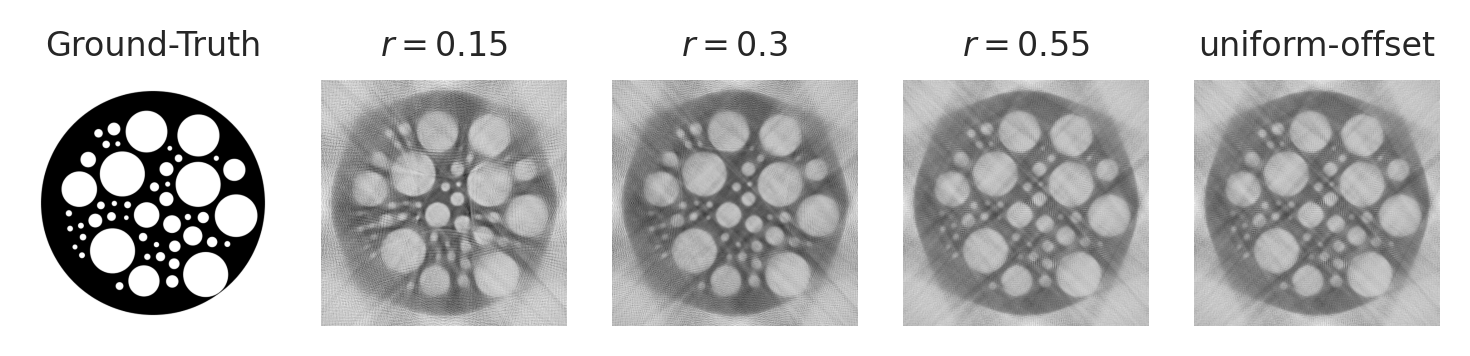

In [34]:
N_op = len(op_para_nu)
fig, ax = plt.subplots(ncols=N_op + 2, figsize=[5, 7])
ax[0].set_title("Ground-Truth")
ax[0].imshow(phantom, **im_kwargs)
ax[0].axis("off")
ax[-1].set_title("uniform-offset")
ax[-1].imshow(I_LSQ, **im_kwargs)
ax[-1].axis("off")
for i, (r, op) in enumerate(op_para_nu):
    # Compute LSQ image. ===============================================
    sinogram = op.apply(phantom.reshape(-1)).reshape(N_angle, N_offset)
    I_LSQ = op.pinv(sinogram.reshape(-1), damp=0).reshape(phantom.shape)

    # Plot it ==========================================================
    ax[i+1].imshow(I_LSQ, **im_kwargs)
    ax[i+1].set_title(f"$r={r}$")
    ax[i+1].axis("off")
fig.tight_layout()


A few takebacks from this experiment:

* If $r$ is small, then the sharp region is limited to a small radius around the image center.
* As $r$ increases, we lose sharpness at the center in favor of peripheral regions.

### Fan Beam

Another potential solution to improve radial resolution is to employ a fan beam geometry.
The advantage of fan beam is potentially more "orientations" being available for the same value of $N_{\mathrm{angle}}$.

We will take the same $N_{\mathrm{angle}}$ and $N_{\mathrm{offset}}$ settings as in parallel beam, but where
$N_{\mathrm{angle}}$ refers to the number of "emitter" locations, and $N_{\mathrm{offset}}$ now corresponds to the
number of detectors spread along the edge of the image.

In [35]:
# In the parallel-beam setups above, we had fixed `origin=0` and shifted `t_spec` to be centered at the volume
# mid-point, i.e. (N_side * pitch / 2). For fan-beam, it is easier to center the volume at the origin of the reference
# system, i.e. `origin = -(N_side * pitch / 2)`, and define `n/t_spec` for one source position. Subsequent src/detector
# positions are then obtained by applying a rotation matrix.

# Let's build the necessary components to instantiate the operator. ========================
radius = (N_side * pitch / np.sqrt(2))  # be at diagonal distance
tx = np.r_[-1, 0] * radius  # (2,)
t_max = N_side * pitch / np.sqrt(2)
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)
rx = np.stack([radius * np.ones(N_offset), t_offset], axis=-1)  # (N_offset, 2)

t = np.broadcast_to(tx, (N_offset, 2))
n = rx - tx  # vectors pointing from unique TX to all RX.

angle = np.linspace(0, 2 * np.pi, N_angle, endpoint=False)
R = np.zeros((N_angle, 2, 2))
R[:, 0, 0] = R[:, 1, 1] = np.cos(angle)
R[:, 1, 0] = np.sin(angle)
R[:, 0, 1] = -np.sin(angle)

n_spec = (R @ n.T).transpose(0, 2, 1)  # (N_angle, N_offset, 2)
t_spec = (R @ t.T).transpose(0, 2, 1)  # (N_angle, N_offset, 2)
# ==========================================================================================


op_fan = pxr.XRayTransform.init(
    arg_shape=(N_side, N_side),
    origin=-N_side * pitch / 2,  # center of volume located at (0, 0)
    pitch=pitch,  # pixel dimensions. (Can vary per axis.)
    method="ray-trace",
    n_spec=n_spec.reshape(-1, 2),  # (N_ray, 2) directions
    t_spec=t_spec.reshape(-1, 2),  # (N_ray, 2)
)


Let's again verify that the rays are instantiated correctly.
We'll limit the visualization to 2 "emitters", and sub-sample the outgoing beam-count for visualization purposes:

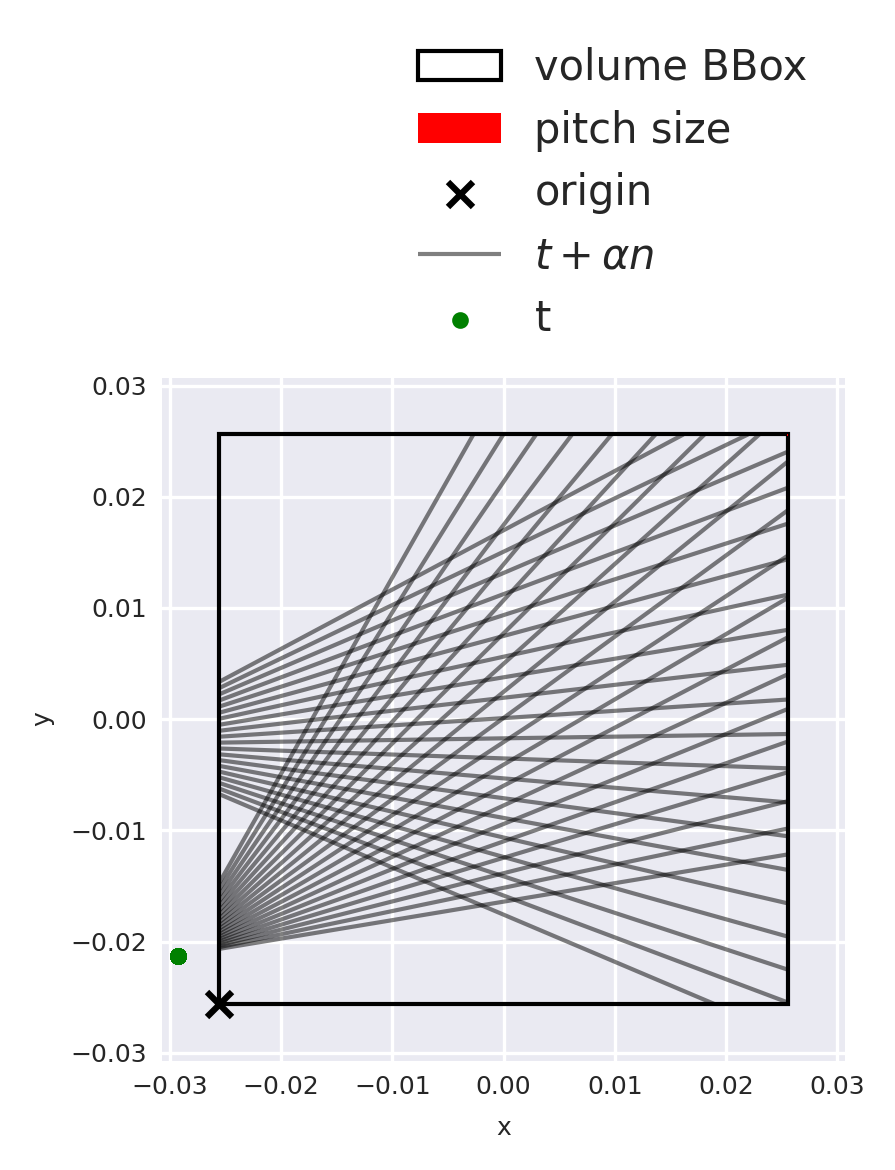

In [37]:
ray_idx = np.arange(N_angle * N_offset).reshape(N_angle, N_offset)[[1, 10], ::10]

fig = op_fan.diagnostic_plot(ray_idx)
fig.show()


We can already see an interesting difference with respect to parallel-beam setups: the ray density is higher in the periphery than in the center region.

Plotting the sinogram is more complex than in the parallel-beam case, so let's skip that step and instead see what the
back-projected and least-squares images look like.

INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:06.189267] Iteration 0
	iteration: 0
	AbsError[residual]: 0.05324661981317398
	N_iter: 1.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:06.781108] Iteration 1
	iteration: 1
	AbsError[residual]: 0.0030504175391676256
	N_iter: 2.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:07.174329] Iteration 2
	iteration: 2
	AbsError[residual]: 0.002050073063966784
	N_iter: 3.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:07.579660] Iteration 3
	iteration: 3
	AbsError[residual]: 0.0008204494986229778
	N_iter: 4.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:07.999506] Iteration 4
	iteration: 4
	AbsError[residual]: 0.00043823673093985297
	N_iter: 5.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:08.425266] Iteration 5
	iteration: 5
	AbsError[residual]: 0.0002602658043562458
	N_iter: 6.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:08.884062] Iteration 6
	iteration: 6
	AbsError[residual]: 0.0001519355648745462
	N_iter: 7.0
INFO:/tmp/pyxu_yxbaj8t3:[2023-11-02 16:02:09.339093] Iter

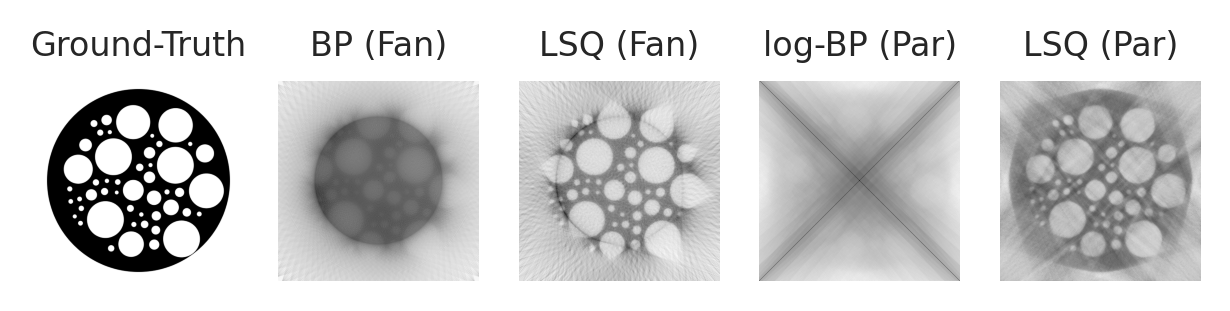

In [39]:
# Compute backprojected image and LSQ image. =======================
sinogram = op_fan.apply(phantom.reshape(-1)).reshape(N_angle, N_offset)
I_BP = op_fan.adjoint(sinogram.reshape(-1)).reshape(phantom.shape)
I_LSQ = op_fan.pinv(sinogram.reshape(-1), damp=0).reshape(phantom.shape)

# Plot the images ==================================================
fig, ax = plt.subplots(1, 5, figsize=[5, 7])
ax[0].imshow(phantom, **im_kwargs)
ax[1].imshow(I_BP, **im_kwargs)
ax[2].imshow(I_LSQ, **im_kwargs)
ax[3].imshow(np.log(I_BP_u), **im_kwargs)
ax[4].imshow(I_LSQ_u, **im_kwargs)
ax[0].set_title("Ground-Truth")
ax[1].set_title("BP (Fan)")
ax[2].set_title("LSQ (Fan)")
ax[3].set_title("log-BP (Par)")
ax[4].set_title("LSQ (Par)")
for _ax in ax:
    _ax.axis("off")


Based on the plots, we can already see some interesting behaviour:

* At equivalent rays cast into the medium, the back-projected fan-image has much higher contrast than the parallel-beam equivalent. (Linear vs. log-scale plot.)
* The least-squares fan-beam image appears sharper & higher-contrast than the parallel beam version, but it warps at
  the borders due to the projection geometry.

A finer analysis is of course possible, but we hope to have shown how the scanning geometry impacts image
reconstruction. The versatile `XRayTransform()`[🔗](../api/experimental/xray.html#pyxu.experimental.xray.XRayTransform)
class is therefore a handy tool in the computational scientist's toolbox!